In [1]:
!pip install efficientnet_pytorch

  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=d49c888d4b2e6312f76f188cb57ba61cdd620e0eff46253bea8c8e22a4b3127a
  Stored in directory: /root/.cache/pip/wheels/0e/cc/b2/49e74588263573ff778da58cc99b9c6349b496636a7e165be6
Successfully built efficientnet-pytorch


In [2]:
from efficientnet_pytorch import EfficientNet
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
# from keras.applications.vgg16 import VGG16 
# from keras.models import Model
# from keras.applications.vgg16 import preprocess_input 
import os
import logging
import torch
from torch import nn
import pickle
from tqdm import tqdm
from torchvision import transforms
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

In [3]:
#dataset path
data_path = '/content/drive/MyDrive/Colab/Sketch_RNN_Together/Dataset/Filtered_img/'
#feature path
feat_path = "/content/drive/MyDrive/Colab/Sketch_RNN/torch_sketch/features_filter.npy"
#filename path
filename_path = "/content/drive/MyDrive/Colab/Sketch_RNN/torch_sketch/filenames_filter.npy"
#cluster_list
cluster_list_path = '/content/drive/MyDrive/Colab/Sketch_RNN_Together/Dataset/Filtered_img/cluster_list.txt'
cluster_list = open(cluster_list_path , 'r').read().split('\n')
#image_save_path
save_path = '/content/drive/MyDrive/Colab/Sketch_RNN/torch_sketch/Result/'
#test_image_path
test_data_path = '/content/drive/MyDrive/Colab/Sketch_RNN_Together/skku_Clustering/test_set/'
# p = r"/content/drive/MyDrive/Colab/Sketch_RNN/torch_sketch/sktch_log.pkl"

In [4]:
import glob
data_list = []
data_list = [files for files in glob.glob(data_path + '*/*.jpg')]
new_data_list = [files for files in glob.glob(test_data_path + '*/*.jpg')]

In [5]:
new_data_list[20:21]

['/content/drive/MyDrive/Colab/Sketch_RNN_Together/skku_Clustering/test_set/cloud/test_cloud_1.jpg']

In [6]:
feat = np.load(feat_path)
filenames = np.load(filename_path)

#### Feature Extraction

In [7]:
#transform
tfms = transforms.Compose([transforms.Resize(224), transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),])
pooling = nn.AdaptiveAvgPool2d(1)

def feature_extraction(image, model):
    img = tfms(Image.open(image).convert("RGB")).unsqueeze(0)
    feature = model.extract_features(img)
    features = pooling(feature)
    return features

In [8]:
#New
model = EfficientNet.from_pretrained('efficientnet-b0')
new_data = {}
for i, image in enumerate(tqdm(new_data_list[20:21])):
  new_feat = feature_extraction(image, model)
  new_feat = new_feat.detach().numpy().reshape(-1)
  new_data[image] = (new_feat)

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth


  0%|          | 0/1 [00:00<?, ?it/s]


Loaded pretrained weights for efficientnet-b0


100%|██████████| 1/1 [00:00<00:00,  1.49it/s]


In [9]:
feat = np.append(feat, np.array(list(new_data.values())), axis = 0)
filenames = np.append(filenames, np.array(list(new_data.keys())), axis = 0)

In [10]:
len(feat)

608

#### Dimension Reduction

In [11]:
#TSNE
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, init='pca', random_state=0)
x = tsne.fit_transform(feat)

In [12]:
len(x)

608

#### Nearest Neighbor


In [13]:
from sklearn.neighbors import NearestNeighbors
knn = NearestNeighbors(n_neighbors=6, algorithm='auto').fit(x)
distances, indices = knn.kneighbors([list(x[-1])])

In [14]:
indices

array([[607, 423, 467, 459, 439, 429]])

In [15]:
for i in indices:
  print(x[i])

[[10.826834  18.016142 ]
 [11.374312  16.664316 ]
 [11.102805  16.56445  ]
 [ 9.2313385 17.835997 ]
 [ 9.4568205 16.448046 ]
 [ 8.571018  17.674765 ]]


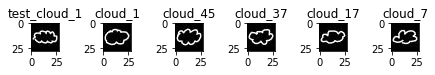

In [16]:
import matplotlib.pyplot as plt
image = []
name = []
for idx in indices[0]:
  image.append(np.array(Image.open(filenames[idx])))
  name.append(filenames[idx].split('/')[-1].split('.')[0])

for i, img in enumerate(image):
  plt.subplot(1,6,i+1)
  plt.title(name[i])
  plt.imshow(img, 'gray')

plt.tight_layout()
plt.show()